In [1]:
# For data manipulation
import pandas as pd              

# Garbage Collector to free up memory
import gc                         
gc.enable()                       # Activate 

In [2]:
orders = pd.read_csv('../input/orders.csv' )
order_products_train = pd.read_csv('../input/order_products__train.csv')
order_products_prior = pd.read_csv('../input/order_products__prior.csv')
products = pd.read_csv('../input/products.csv')
aisles = pd.read_csv('../input/aisles.csv')
departments = pd.read_csv('../input/departments.csv')

In [3]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [5]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [8]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [9]:
# We convert character variables into category. 
# In Python, a categorical variable is called category and has a fixed number of different values
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

In [10]:
#Create a DataFrame with the orders and the products that have been purchased on prior orders (op)
#Merge the orders DF with order_products_prior by their order_id, keep only these rows with order_id that they are appear on both DFs
op = orders.merge(order_products_prior, on='order_id', how='inner')
op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


# 2. Create Predictor Variables
We are now ready to identify and calculate predictor variables based on the provided data. We can create various types of predictors such as:
* <b>User predictors</b> describing the behavior of a user e.g. total number of orders of a user.
* <b>Product predictors</b> describing characteristics of a product e.g. total number of times a product has been purchased.
* <b>User & product predictors</b> describing the behavior of a user towards a specific product e.g. total times a user ordered a specific product.

In [11]:
#Number of orders per customer
# Create distinct groups for each user, identify the highest order number in each group, save the new column to a DataFrame
user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
# Reset the index of the DF so to bring user_id from index to column (pre-requisite for step 2.4)
user = user.reset_index()
user.head()


,user_id,u_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [12]:
#How frequent a customer has reordered products
u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')
u_reorder = u_reorder.reset_index()
u_reorder.head()

,user_id,u_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


In [13]:
user = user.merge(u_reorder, on='user_id', how='left')

del u_reorder
gc.collect()

user.head()

,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


**Create product predictors**

In [14]:
#Number of purchases for each product
# Create distinct groups for each product, count the orders, save the result for each product to a new DataFrame  
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd = prd.reset_index()
prd.head()

,product_id,p_total_purchases
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


**What is the probability for a product to be reordered**

In [15]:
#Remove products with less than 40 purchases
# the x on lambda function is a temporary variable which represents each group
# shape[0] on a DataFrame returns the number of rows
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >40)
p_reorder.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [16]:
#Group products, calculate the mean of reorders
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
p_reorder.head()

,product_id,p_reorder_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,8,0.503030


In [17]:
#Merge the prd DataFrame with reorder
prd = prd.merge(p_reorder, on='product_id', how='left')

#delete the reorder DataFrame
del p_reorder
gc.collect()

prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,NaN


In [18]:
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.000000


In [19]:
# Create distinct groups for each combination of user and product, count orders, save the result for each user X product to a new DataFrame 
uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
# Reset the index of the DF so to bring user_id & product_id rom indices to columns (pre-requisite for step 2.4)
uxp = uxp.reset_index()
uxp.head()

,user_id,product_id,uxp_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [20]:
#last 5 orders
op['order_number_back'] = op.groupby('user_id')['order_number'].transform(max) - op.order_number +1 
op5 = op[op.order_number_back <= 5]
last_five = op5.groupby(['user_id','product_id'])[['order_id']].count()
last_five.columns = ['times_last5']
last_five['times_last5_ratio'] = last_five.times_last5 / 5
#last_five = last_five.drop(['times_last5_y','times_last5_ratio_y'])
#############
uxp = uxp.merge(last_five , on=['user_id', 'product_id'], how='left')
del [last_five]
gc.collect()
uxp.head()

,user_id,product_id,uxp_total_bought,times_last5,times_last5_ratio
0,1,196,10,5.0,1.0
1,1,10258,9,5.0,1.0
2,1,10326,1,NaN,NaN
3,1,12427,10,5.0,1.0
4,1,13032,3,2.0,0.4


In [21]:
uxp['times_last5'] = uxp['times_last5'].fillna(value=0)
uxp['times_last5_ratio'] = uxp['times_last5_ratio'].fillna(value=0)
uxp.head()

,user_id,product_id,uxp_total_bought,times_last5,times_last5_ratio
0,1,196,10,5.0,1.0
1,1,10258,9,5.0,1.0
2,1,10326,1,0.0,0.0
3,1,12427,10,5.0,1.0
4,1,13032,3,2.0,0.4


**How frequently a customer bought a product after its first purchase**

Calculating the numerator - How many times a customer bought a product? ('Times_Bought_N')

In [22]:
times = op5.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
times.head()

Times_Bought_N
user_id product_id                
1       196                      5
        10258                    5
        12427                    5
        13032                    2
        25133                    5

**Calculating the denumerator**

In [23]:
#The total number of orders for each customer ('total_orders')
total_orders = op5.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders.head()

,total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


#### 2.3.2.2.b The order number where the customer bought a product for first time ('first_order_number')
Where for first_order_number we .groupby( ) by both user_id & product_id. As we want to get the order when a product has been purchases for first time, we select the order_number column and we retrieve with .min( ) aggregation function, the earliest order.

In [24]:
first_order_no = op5.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no  = first_order_no.reset_index()
first_order_no.head()

,user_id,product_id,first_order_number
0,1,196,6
1,1,10258,6
2,1,12427,6
3,1,13032,7
4,1,25133,6


We merge the first order number with the total_orders DataFrame. As total_orders refers to all users, where first_order_no refers to unique combinations of user & product, we perform a right join


In [25]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
span.head()

,user_id,total_orders,product_id,first_order_number
0,1,10,196,6
1,1,10,10258,6
2,1,10,12427,6
3,1,10,13032,7
4,1,10,25133,6


#### 2.3.2.2.c For each product get the total orders placed since its first order ('Order_Range_D')
The denominator now can be created with simple operations between the columns of results DataFrame:

In [26]:
# The +1 includes in the difference the first order were the product has been purchased
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
span.head()

,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,1,10,196,6,5
1,1,10,10258,6,5
2,1,10,12427,6,5
3,1,10,13032,7,4
4,1,10,25133,6,5


### 2.3.2.3 Create the final ratio "uxp_order_ratio"
#### 2.3.2.3.a Merge the DataFrames of numerator & denumerator


In [27]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,1,196,5,10,6,5
1,1,10258,5,10,6,5
2,1,12427,5,10,6,5
3,1,13032,2,10,7,4
4,1,25133,5,10,6,5


####  2.3.2.3.b  Perform the final division
Now we divide theTimes_Bought_N by the Order_Range_D for each user and product.

In [28]:
uxp_ratio['uxp_order_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_order_ratio
0,1,196,5,10,6,5,1.0
1,1,10258,5,10,6,5,1.0
2,1,12427,5,10,6,5,1.0
3,1,13032,2,10,7,4,0.5
4,1,25133,5,10,6,5,1.0


####  2.3.2.3.c Keep the final feature
Here we select to keep only the 'user_id', 'product_id' and the final feature 'uxp2_order_ratio'


In [29]:
uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
uxp_ratio.head()

,user_id,product_id,uxp_order_ratio
0,1,196,1.0
1,1,10258,1.0
2,1,12427,1.0
3,1,13032,0.5
4,1,25133,1.0


In [30]:
#Remove temporary DataFrames
del [times, first_order_no, span,op5]


### 2.3.2.4 Merge the final feature with uxp DataFrame


In [31]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio
uxp.head()

,user_id,product_id,uxp_total_bought,times_last5,times_last5_ratio,uxp_order_ratio
0,1,196,10,5.0,1.0,1.0
1,1,10258,9,5.0,1.0,1.0
2,1,10326,1,0.0,0.0,NaN
3,1,12427,10,5.0,1.0,1.0
4,1,13032,3,2.0,0.4,0.5


## 2.4 Merge all features
We now merge the DataFrames with the three types of predictors that we have created (i.e., for the users, the products and the combinations of users and products).

We will start from the **uxp** DataFrame and we will add the user and prd DataFrames. We do so because we want our final DataFrame (which will be called **data**) to have the following structure: 

<img style="float: left;" src="https://i.imgur.com/mI5BbFE.jpg" >






### 2.4.1 Merge uxp with user DataFrame
Here we select to perform a left join of uxp with user DataFrame based on matching key "user_id"

<img src="https://i.imgur.com/WlI84Ud.jpg" width="400">

Left join, ensures that the new DataFrame will have:
- all the observations of the uxp (combination of user and products) DataFrame 
- all the **matching** observations of user DataFrame with uxp based on matching key **"user_id"**

The new DataFrame as we have already mentioned, will be called **data**.

In [32]:
#Merge uxp features with the user features
#Store the results on a new DataFrame
data = uxp.merge(user, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_total_bought,times_last5,times_last5_ratio,uxp_order_ratio,u_total_orders,u_reordered_ratio
0,1,196,10,5.0,1.0,1.0,10,0.694915
1,1,10258,9,5.0,1.0,1.0,10,0.694915
2,1,10326,1,0.0,0.0,NaN,10,0.694915
3,1,12427,10,5.0,1.0,1.0,10,0.694915
4,1,13032,3,2.0,0.4,0.5,10,0.694915


### 2.4.1 Merge data with prd DataFrame
In this step we continue with our new DataFrame **data** and we perform a left join with prd DataFrame. The matching key here is the "product_id".
<img src="https://i.imgur.com/Iak6nIz.jpg" width="400">

Left join, ensures that the new DataFrame will have:
- all the observations of the data (features of userXproducts and users) DataFrame 
- all the **matching** observations of prd DataFrame with data based on matching key **"product_id"**

In [33]:
#Merge uxp & user features (the new DataFrame) with prd features
data = data.merge(prd, on='product_id', how='left')
data.head()

,user_id,product_id,uxp_total_bought,times_last5,times_last5_ratio,uxp_order_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,196,10,5.0,1.0,1.0,10,0.694915,35791,0.776480
1,1,10258,9,5.0,1.0,1.0,10,0.694915,1946,0.713772
2,1,10326,1,0.0,0.0,NaN,10,0.694915,5526,0.652009
3,1,12427,10,5.0,1.0,1.0,10,0.694915,6476,0.740735
4,1,13032,3,2.0,0.4,0.5,10,0.694915,3751,0.657158


### 2.4.2 Delete previous DataFrames

The information from the DataFrames that we have created to store our features (op, user, prd, uxp) is now stored on **data**. 

As we won't use them anymore, we now delete them.

In [34]:
del op, user, prd, uxp
gc.collect()

180

# 3. Create train and test DataFrames


In [35]:
orders_last = orders[(orders.eval_set=='train') | (orders.eval_set=='test') ]

In [36]:
data = data.merge(orders_last, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_total_bought,times_last5,times_last5_ratio,uxp_order_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,196,10,5.0,1.0,1.0,10,0.694915,35791,0.776480,1187899,train,11,4,8,14.0
1,1,10258,9,5.0,1.0,1.0,10,0.694915,1946,0.713772,1187899,train,11,4,8,14.0
2,1,10326,1,0.0,0.0,NaN,10,0.694915,5526,0.652009,1187899,train,11,4,8,14.0
3,1,12427,10,5.0,1.0,1.0,10,0.694915,6476,0.740735,1187899,train,11,4,8,14.0
4,1,13032,3,2.0,0.4,0.5,10,0.694915,3751,0.657158,1187899,train,11,4,8,14.0


In [37]:
data_train = data[data.eval_set=='train']

data_train = data_train.merge(order_products_train, on=['product_id', 'order_id'], how='left' )

data_train = data_train.drop(['order_id','eval_set', 'add_to_cart_order'], axis=1)
data_train = data_train.fillna(0)
data_train.head()

,user_id,product_id,uxp_total_bought,times_last5,times_last5_ratio,uxp_order_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,1,196,10,5.0,1.0,1.0,10,0.694915,35791,0.776480,11,4,8,14.0,1.0
1,1,10258,9,5.0,1.0,1.0,10,0.694915,1946,0.713772,11,4,8,14.0,1.0
2,1,10326,1,0.0,0.0,0.0,10,0.694915,5526,0.652009,11,4,8,14.0,0.0
3,1,12427,10,5.0,1.0,1.0,10,0.694915,6476,0.740735,11,4,8,14.0,0.0
4,1,13032,3,2.0,0.4,0.5,10,0.694915,3751,0.657158,11,4,8,14.0,1.0


In [38]:
data_test = data[data.eval_set=='test']
data_test = data_test.drop(['eval_set', 'order_id'], axis=1)
data_test = data_test.fillna(0)
data_test.head()

,user_id,product_id,uxp_total_bought,times_last5,times_last5_ratio,uxp_order_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,order_number,order_dow,order_hour_of_day,days_since_prior_order
120,3,248,1,0.0,0.0,0.000000,12,0.625,6371,0.400251,13,5,15,11.0
121,3,1005,1,1.0,0.2,0.333333,12,0.625,463,0.440605,13,5,15,11.0
122,3,1819,3,0.0,0.0,0.000000,12,0.625,2424,0.492162,13,5,15,11.0
123,3,7503,1,0.0,0.0,0.000000,12,0.625,12474,0.553551,13,5,15,11.0
124,3,8021,1,0.0,0.0,0.000000,12,0.625,27864,0.591157,13,5,15,11.0


In [39]:
del data
del orders_last
gc.collect()

185

In [40]:
data_train = data_train.set_index(['user_id', 'product_id'])
data_test = data_test.set_index(['user_id', 'product_id'])

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:34:03] WARNING: /workspace/src/learner.cc:685: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-logloss:0.631466
[10]	train-logloss:0.335568
[20]	train-logloss:0.269682
[30]	train-logloss:0.252933
[40]	train-logloss:0.249401
[50]	train-logloss:0.247775
[60]	train-logloss:0.247156
[70]	train-logloss:0.246852
[79]	train-logloss:0.246646


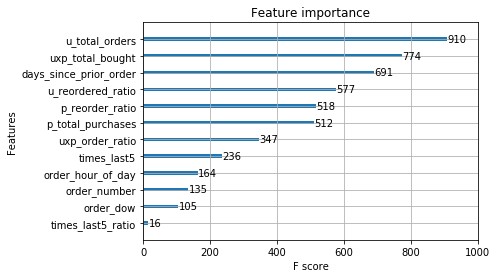

In [41]:
import xgboost
from sklearn.model_selection import train_test_split
data_train.loc[:, 'reordered'] = data_train.reordered.fillna(0)


# subsample
X_train, X_val, y_train, y_val = train_test_split(data_train.drop('reordered', axis=1), data_train.reordered,
                                                    test_size=0.2, random_state=42)

del data_train
gc.collect()

d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}

watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst)

In [42]:
del [X_train, X_val, y_train, y_val]
gc.collect()

7

In [43]:
d_test = xgboost.DMatrix(data_test)

data_test = data_test.reset_index()
data_test = data_test[['product_id', 'user_id']]

data_test["reordered"] = (bst.predict(d_test) > 0.21).astype(int)

del bst

In [44]:
orders_test = orders[orders.eval_set=='test']

In [45]:
data_test = data_test.merge(orders_test[["user_id", "order_id"]], on='user_id', how='left')
data_test.head()

,product_id,user_id,reordered,order_id
0,248,3,0,2774568
1,1005,3,0,2774568
2,1819,3,0,2774568
3,7503,3,0,2774568
4,8021,3,0,2774568


In [46]:
del orders
del orders_test
gc.collect()

39

In [47]:
data_test['product_id'] = data_test.product_id.astype(int)
data_test = data_test.drop('user_id', axis=1)
gc.collect()


0

In [48]:
d = dict()
for row in data_test.itertuples():
    if row.reordered == 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in data_test.order_id:
    if order not in d:
        d[order] = 'None'
        
gc.collect()

0

In [49]:
sub = pd.DataFrame.from_dict(d, orient='index')
sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']

sub.to_csv('sub.csv', index=False)

In [50]:
submission = pd.read_csv("../working/sub.csv")
submission.head()

,order_id,products
0,2774568,17668 18599 21903 23650 39190 43961 47766
1,1528013,8424 21903 38293
2,1376945,8309 13176 14947 27959 28465 33572 34658 35948...
3,1356845,7076 10863 11520 13176 14992
4,2161313,196 10441 11266 12427 14715 27839 37710 48142


In [51]:
submission.shape[0]

75000